<a href="https://colab.research.google.com/github/Tejas163/DataScience-Deep-Learning-course/blob/master/Foundations_DL2_FastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

1. Get data
2. Normalize data

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [0]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [6]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.0001), tensor(1.))

In [0]:
#export
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [0]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [9]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

**Basic architecture**

In [0]:
# num hidden layers
nh = 50

In [0]:
# simplified kaiming init / he init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [12]:
# This should be ~ (0,1) (mean,std)...
x_valid.mean(),x_valid.std()

(tensor(-0.0057), tensor(0.9924))

In [0]:
def lin(x, w, b): return x@w + b       #iter1-linear layer

In [0]:
t = lin(x_valid, w1, b1)

In [15]:
t.mean(),t.std()

(tensor(0.0959), tensor(0.9207))

In [0]:
#Applying relu
def relu(x): return x.clamp_min(0.)

In [0]:
t = relu(lin(x_valid, w1, b1))

In [18]:
t.mean(),t.std()

(tensor(0.4154), tensor(0.5756))

This is He initialization introduced in the paper [Diving Deep into rectifiers](https://arxiv.org/abs/1502.01852)

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$


In [0]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [20]:
w1.mean(),w1.std()

(tensor(-0.0005), tensor(0.0503))

In [21]:
t = relu(lin(x_valid, w1, b1))
t.mean(),t.std()

(tensor(0.5013), tensor(0.7908))

In [0]:
#export
from torch.nn import init

In [0]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))

In [0]:
init.kaiming_normal_??

In [25]:
w1.mean(),w1.std()

(tensor(0.0001), tensor(0.0504))

In [26]:
t.mean(),t.std()


(tensor(0.5007), tensor(0.7778))

In [27]:
w1.shape

torch.Size([784, 50])

**iteration1:Model**

In [0]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

**Loss function:MSE**

In [0]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()


In [0]:
y_train,y_valid = y_train.float(),y_valid.float()

In [0]:
preds = model(x_train)

In [32]:
preds.shape


torch.Size([50000, 1])

In [33]:
mse(preds, y_train)


tensor(29.2914)

**Gradients and backward pass**

In [0]:
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [0]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [0]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [0]:

def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [0]:
forward_and_backward(x_train, y_train)

In [0]:
# Save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

**Layers as classes**

In [0]:
#ReLu layer 
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [0]:
#Linear layer
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [0]:
#Loss function

class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [0]:
#Model
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [45]:
%time loss = model(x_train, y_train)


CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 116 ms


In [46]:
%time model.backward()

CPU times: user 3.07 s, sys: 3.81 s, total: 6.88 s
Wall time: 6.89 s


**Using Module concept from PyTorch but creating own**

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [0]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [0]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [0]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [53]:
%time loss = model(x_train, y_train)


CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 119 ms


In [54]:
%time model.backward()

CPU times: user 206 ms, sys: 81 ms, total: 287 ms
Wall time: 298 ms


**Using nn.Linear and nn.Module from PyTorch**

In [0]:
from torch import nn


In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [0]:
model = Model(m, nh, 1)

In [58]:
%time loss = model(x_train, y_train)


CPU times: user 95 ms, sys: 903 µs, total: 95.9 ms
Wall time: 104 ms


In [59]:
%time loss.backward()


CPU times: user 77.6 ms, sys: 6.39 ms, total: 84 ms
Wall time: 161 ms


The time taken by creating own module vs using PyTorch ones is significant as in the time taken by PyTorch is **less**

**Lesson 3 continued**

In [0]:
import torch.nn.functional as F


In [0]:
x_train,y_train,x_valid,y_valid = get_data()


In [0]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(m, nh, 10)


In [0]:
pred = model(x_train)


**Cross entropy loss**

In [0]:
#we need log of softmax while calculating loss

def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()


In [0]:
sm_pred = log_softmax(pred)


In [68]:
sm_pred

tensor([[-2.4944, -2.1244, -2.4125,  ..., -2.3106, -2.4204, -2.1940],
        [-2.5721, -2.0990, -2.4358,  ..., -2.3145, -2.3960, -2.1336],
        [-2.5293, -2.1487, -2.3490,  ..., -2.3299, -2.3839, -2.1699],
        ...,
        [-2.5904, -2.1209, -2.3050,  ..., -2.2742, -2.3699, -2.2176],
        [-2.6380, -2.1428, -2.3375,  ..., -2.2921, -2.3032, -2.2002],
        [-2.5547, -2.1418, -2.2902,  ..., -2.2871, -2.3858, -2.2073]],
       grad_fn=<LogBackward>)

In [69]:
y_train[:3]


tensor([5, 0, 4])

In [70]:
sm_pred[[0,1,2], [5,0,4]]


tensor([-2.1449, -2.5721, -2.3935], grad_fn=<IndexBackward>)

In [71]:
y_train.shape[0]


50000

In [0]:
#negative log loss function
def nll(input, target): return -input[range(target.shape[0]), target].mean()


In [0]:
loss = nll(sm_pred, y_train)


In [74]:
loss

tensor(2.3081, grad_fn=<NegBackward>)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where a is the maximum of the $x_{j}$.

In [0]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This is already present  In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.



In [76]:
F.cross_entropy(pred, y_train)


tensor(2.3081, grad_fn=<NllLossBackward>)

Training loop


Basically the training loop repeats over the following steps:

get the output of the model on a batch of inputs
compare the output to the labels we have and compute a loss
calculate the gradients of the loss with respect to every parameter of the model
update said parameters with those gradients to make them a little bit better

In [0]:
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()


In [78]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.1700,  0.2000, -0.0882, -0.1203, -0.0266,  0.1795,  0.1141,  0.0137,
         -0.0961,  0.1304], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [0]:

lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [81]:
loss_func(model(xb), yb), accuracy(model(xb), yb)


(tensor(0.0935, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)


In [84]:
for name,l in model.named_children(): print(f"{name}: {l}")


l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [85]:
model


Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:

def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [87]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0377, grad_fn=<NllLossBackward>), tensor(1.))

In [0]:

class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
    # PYtorch overrides __setattr __ in nn.Module with the sub module we are defining 
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [89]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [90]:
[o.shape for o in mdl.parameters()]


[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

Registering modules

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]


In [0]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(layers)


In [94]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
#using nn.ModuleList provided by PyTorch

class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = SequentialModel(layers)


In [97]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [98]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))                  #nn.Sequential from pyTorch
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1490, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
#replacing the previous optimization function in fit by calling Optimizer class
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))


In [0]:
opt = Optimizer(model.parameters())


In [0]:
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred=model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [103]:

loss,acc=loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0736, grad_fn=<NllLossBackward>), tensor(1.))

**Dataset and  Dataloader**

In [0]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [106]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [0]:
from torch import optim


def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
model,opt = get_model()


In [109]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2583, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [111]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1213, grad_fn=<NllLossBackward>), tensor(0.9375))

**DataLoader**

In [0]:
#DataLoader
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

In [0]:
model,opt = get_model()


In [0]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [118]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1308, grad_fn=<NllLossBackward>), tensor(0.9688))

**Random sampling**

In [0]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])


In [121]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

After sampling by setting to true

In [122]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([9, 4, 3]), tensor([5, 2, 0]), tensor([6, 7, 8]), tensor([1])]

In [0]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

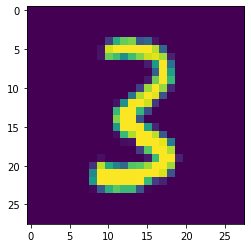

In [126]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

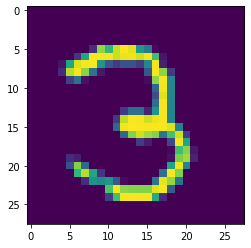

In [127]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

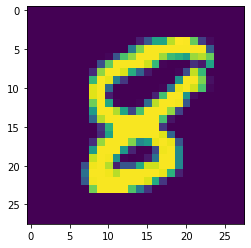

In [128]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [129]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2910, grad_fn=<NllLossBackward>), tensor(0.9062))

**PyTorch DataLoader**

In [0]:
#Sampling
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [132]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3248, grad_fn=<NllLossBackward>), tensor(0.9062))

In [0]:
#with defaults

train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [134]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2268, grad_fn=<NllLossBackward>), tensor(0.9219))

**Having a validation set and finding validation loss**

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [137]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1715) tensor(0.9489)
1 tensor(0.1424) tensor(0.9576)
2 tensor(0.1150) tensor(0.9660)
3 tensor(0.1082) tensor(0.9680)
4 tensor(0.1123) tensor(0.9680)


In [0]:
assert acc>0.9


**Callbacks**

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [145]:
loss,acc = fit(1, learn)


0 tensor(0.2960) tensor(0.9082)


**Callback Handler**- Add callbacks so we can remove complexity from loop, and make it flexible:



In [0]:

def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

def all_batches(dl, cb):
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [0]:

class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [0]:
class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

In [0]:
class TestCallback(Callback):
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True
        
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
        return True

In [150]:
fit(1, learn, cb=CallbackHandler([TestCallback()]))


1
2
3
4
5
6
7
8
9
10


**Runner**

In [0]:

#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

This first callback is reponsible to switch the model back and forth in training or validation mode, as well as maintaining a count of the iterations, or the percentage of iterations ellapsed in the epoch.

In [0]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [0]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters>=10: return True

In [154]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [155]:
TrainEvalCallback().name


'train_eval'

In [0]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False


Third callback metrics computing

In [0]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
learn = Learner(*get_model(data), loss_func, data)


In [0]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [161]:
run.fit(2, learn)


train: [0.3123357421875, tensor(0.9044)]
valid: [0.14417196044921876, tensor(0.9590)]
train: [0.134897421875, tensor(0.9586)]
valid: [0.14034197998046874, tensor(0.9582)]


In [162]:
loss,acc = stats.valid_stats.avg_stats
assert acc>0.9
loss,acc

(0.14034197998046874, tensor(0.9582))

In [0]:
from functools import partial


In [0]:
acc_cbf = partial(AvgStatsCallback,accuracy)


In [0]:
run = Runner(cb_funcs=acc_cbf)


In [166]:
run.fit(1, learn)


train: [0.104704658203125, tensor(0.9679)]
valid: [0.107765869140625, tensor(0.9699)]


In [167]:
run.avg_stats.valid_stats.avg_stats


[0.107765869140625, tensor(0.9699)]

In [0]:

x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)


In [0]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [171]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6770109375, tensor(0.8002)]
valid: [0.2978267578125, tensor(0.9124)]
train: [0.295486953125, tensor(0.9148)]
valid: [0.236236279296875, tensor(0.9370)]
train: [0.2383426953125, tensor(0.9312)]
valid: [0.2029521484375, tensor(0.9442)]


In [172]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.755746015625, tensor(0.8012)]
valid: [0.3432432373046875, tensor(0.9033)]
train: [0.342890703125, tensor(0.9005)]
valid: [0.2906502197265625, tensor(0.9167)]
train: [0.291482109375, tensor(0.9156)]
valid: [0.25729189453125, tensor(0.9269)]


In [0]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)


Annealer-We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

In [0]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()


simple linear scheduler with annealer

In [0]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [176]:
f = sched_lin(1,2)
f(0.3)

1.3

In [0]:
#other linear scheduler functions
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

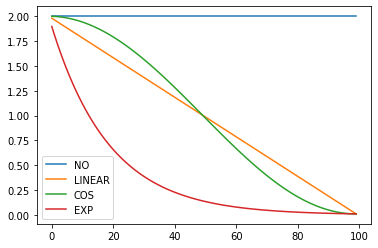

In [178]:

annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [0]:
#combining different schedulers
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])


In [181]:
plt.plot(a, [sched(o) for o in p])


IndexError: ignored

In [0]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [0]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [184]:
run.fit(3, learn)


train: [0.758496484375, tensor(0.7891)]
valid: [0.3031236083984375, tensor(0.9120)]
train: [0.29046642578125, tensor(0.9152)]
valid: [0.232274609375, tensor(0.9331)]
train: [0.23071177734375, tensor(0.9337)]
valid: [0.20671123046875, tensor(0.9425)]


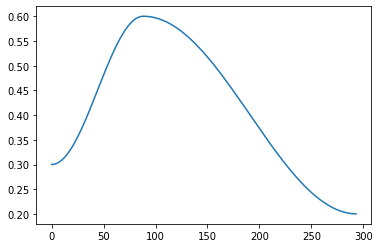

In [185]:
run.recorder.plot_lr()


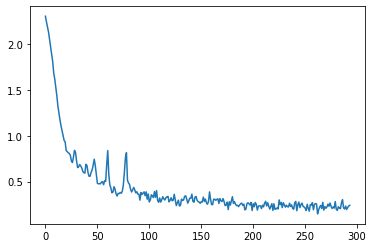

In [186]:
run.recorder.plot_loss()


Variance

In [0]:
t = torch.tensor([1.,2.,4.,18])

In [188]:
m = t.mean(); m

tensor(6.2500)

In [189]:
(t-m).mean()

tensor(0.)

the above doesn't work since positive and negative cancels out.

In [192]:
(t-m).pow(2).mean()            #variance- It's a measure of how spread out the data is, and is particularly sensitive to outliers


tensor(47.1875)

In [191]:
(t-m).abs().mean()            #mean absolute deviation


tensor(5.8750)

In [193]:
#standard deviation
(t-m).pow(2).mean().sqrt()


tensor(6.8693)

In [0]:
t = torch.tensor([1.,2.,4.,18])

In [0]:
v = torch.randn_like(t)

In [200]:
#covariance
cov = (t*v).mean() - t.mean()*v.mean(); cov


tensor(-5.6319)

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [201]:
#Pearson correlation coefficient
cov / (t.std() * v.std())


tensor(-0.4627)

**Softmax**

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()


which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$
And our cross entropy loss is:$$-\log(p_{i})$$